# Fitting with MCMC

This is taken directly from the [emcee](https://emcee.readthedocs.io/en/stable/) tutorials. The concept is to simulate linear data with normal uncertainties, but the reported uncertainties *underestimate* the true uncertainties by some constant fractional amount. Thus in addition to the usual intercept and slope $a$ and $b$ there is also a nuisance parameter $f$ (or $\ln{f}$).

In [1]:
import numpy as np
from scipy.optimize import minimize

import emcee
import corner

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=18)
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', serif='palatino')

## Model Generation

Generate a linear data set with uncertainties distributed according to $\mathcal{N}(0.1,0.5)$. The default intercept $a$, slope $b$, and underestimate fraction $f$ are defined below.

In [2]:
np.random.seed(123)

# Choose the "true" parameters.
a_true = 4.294
b_true = -0.9594
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = a_true + b_true*x
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

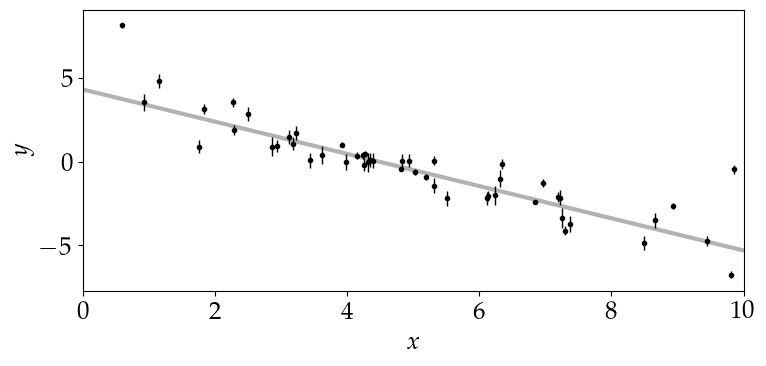

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)

ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)

x0 = np.linspace(0, 10, 500)
ax.plot(x0, a_true + b_true*x0, 'k', alpha=0.3, lw=3)
ax.set(xlim=(0,10), xlabel='$x$', ylabel='$y$');

## LLS Estimate

In [4]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("a = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))
print("b = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))

Least-squares estimates:
a = 5.441 ± 0.091
b = -1.104 ± 0.016


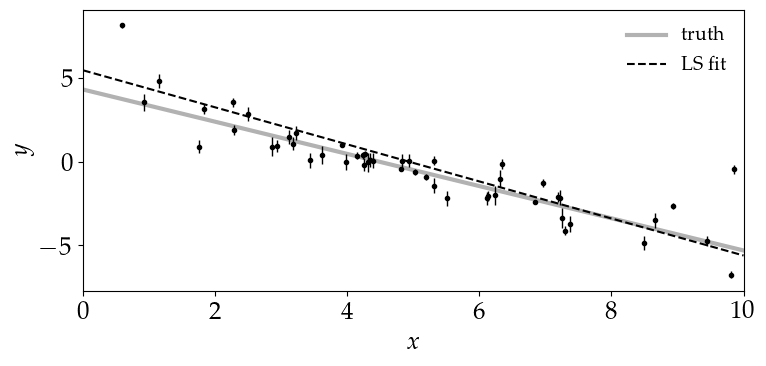

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)

ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)

x0 = np.linspace(0, 10, 500)
ax.plot(x0, a_true + b_true*x0, 'k', alpha=0.3, lw=3, label='truth')
ax.plot(x0, np.dot(np.vander(x0, 2), w), '--k', label='LS fit')
ax.legend(fontsize=14).get_frame().set_linewidth(0)
ax.set(xlim=(0,10), xlabel='$x$', ylabel='$y$');

## Maximum Likelihood

Fit with a Gaussian log-likelihood that includes the fractional underestimate in the variance of each point:

$$
\ln{\mathcal{L}} = \ln{p(y|a,b,f)} =
-\frac{1}{2}\sum_{i=1}^N \left[\left(\frac{y_i-a-bx_i}{s_i}\right)^2 + \ln{(2\pi s_i^2)}\right],
$$

where

$$
s_i^2 = \sigma_i^2 + f^2(a + bx_i)^2.
$$

Note that in the log-likelihood the model parameter will actually be $\ln{f}$.

In [6]:
def logl(pars, x, y, dy):
    a, b, log_f = pars
    model = a +  b*x
    s2 = dy**2 + model**2 * np.exp(2*log_f)
    return -0.5 * np.sum((y - model)**2 / s2 + np.log(s2))

In [7]:
np.random.seed(42)
nll = lambda *args: -logl(*args)
initial = np.array([a_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
a_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a = 4.528
b = -1.003
f = 0.454


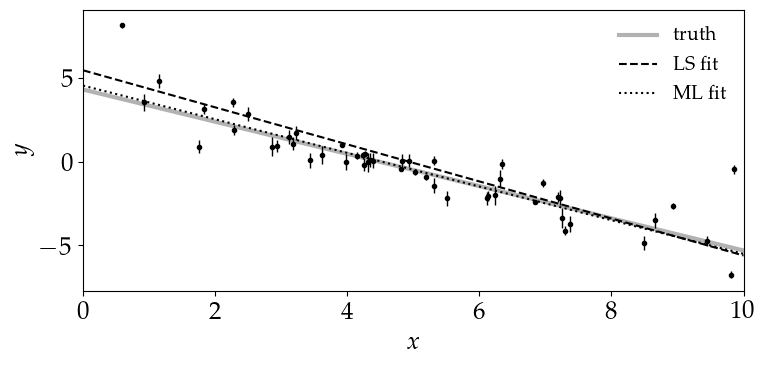

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)

ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)

x0 = np.linspace(0, 10, 500)
ax.plot(x0, a_true + b_true*x0, 'k', alpha=0.3, lw=3, label='truth')
ax.plot(x0, np.dot(np.vander(x0, 2), w), '--k', label='LS fit')
ax.plot(x0, np.dot(np.vander(x0, 2), [b_ml, a_ml]), ":k", label="ML fit")
ax.legend(fontsize=14).get_frame().set_linewidth(0)
ax.set(xlim=(0,10), xlabel='$x$', ylabel='$y$');

## MCMC

In the MCMC we're going to perform a Bayesian computation of the posterior

$$
p(a,b,f|y) \propto p(y|a,b,f) p(a,b,f).
$$

We will assume the joint prior $p(a,b,f)$ can be factorized into three separate uniform priors:

$$
\begin{align*}
p(a,b,f) &= p(a)\cdot p(b)\cdot p(f), &
a &\sim U(0,10), &
b &\sim U(-5,5), &
\ln{f} &\sim U(-10,1).
\end{align*}
$$

I.e., the prior on $f$ is a Jeffreys prior.

### Prior

Ignore the usual normalization factors and just set the joint prior to a constant.

In [9]:
def log_prior(pars):
    a, b, log_f = pars
    if 0.0 < a < 10.0 and -5.0 < b < 0.5 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

### Posterior: Combined Likelihood and Prior

In [10]:
def log_prob(pars, x, y, dy):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logl(pars, x, y, dy)

### Run MCMC: ML Seed

Run the MCMC with 32 "walkers." Seed the walkers using the ML solution.
This can be used to estimate the uncertainties on the parameters.

In [11]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
print(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

32 3


100%|██████████| 5000/5000 [00:07<00:00, 635.89it/s]


#### Plot the Chains

C:\Users\andre\AppData\Local\Temp\ipykernel_27812\738314820.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


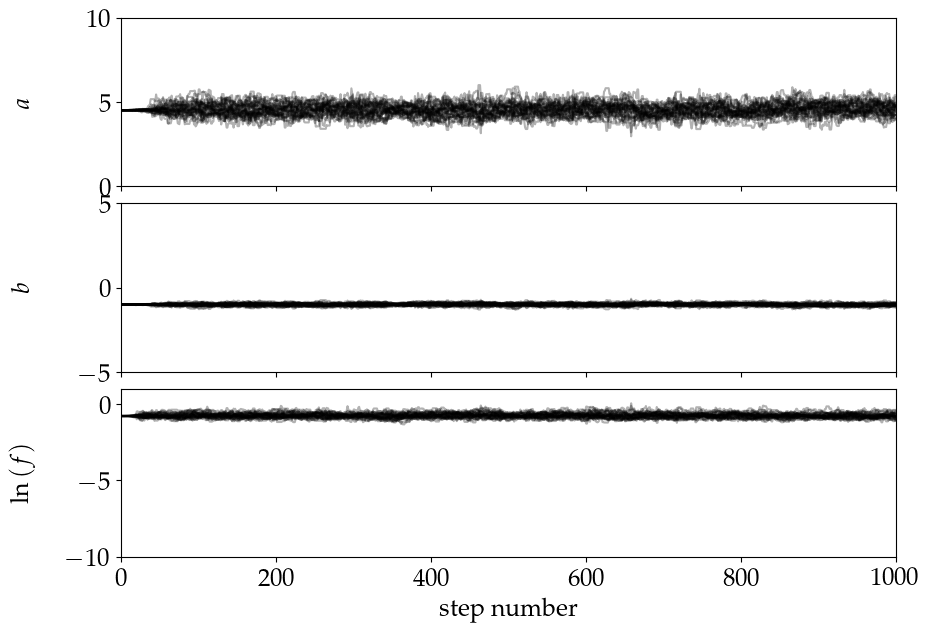

In [12]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
samples = sampler.get_chain()

labels = ['$a$', '$b$', r'$\ln{(f)}$']
yrange = [(0,10), (-5,5), (-10,1)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylim=yrange[i], ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number')
fig.tight_layout()

#### Check Autocorrelation

Check the autocorrelation time and throw away the burn-in.

In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[38.88401228 38.71662404 39.14389526]


Discard the first 100 samples, thin by half the autocorrelation time, and flatten.

In [14]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


#### Generate a Corner Plot

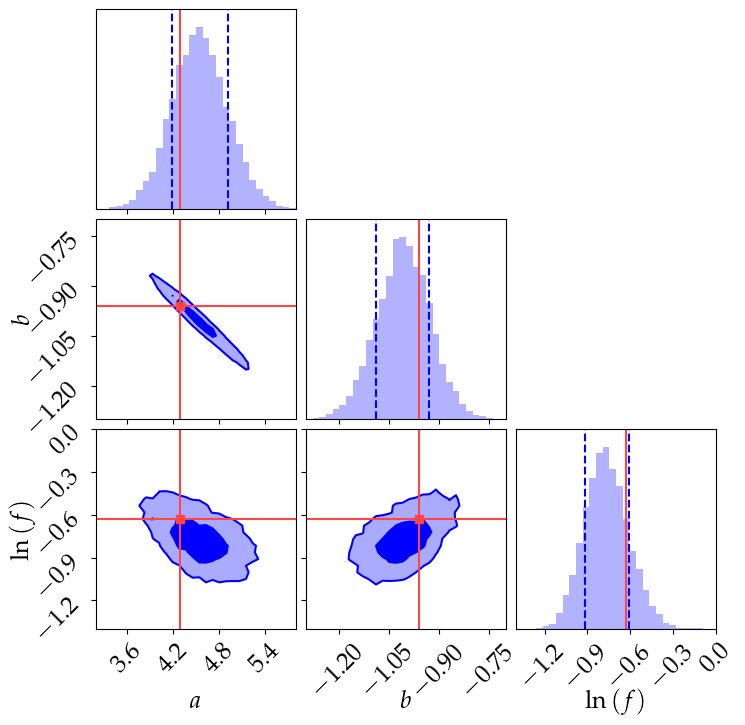

In [15]:
fig = corner.corner(flat_samples, labels=labels,
                    range=[(3.2,5.8), (-1.3,-0.7), (-1.4,0)], bins=30, #smooth=1,
                    truths=[a_true, b_true, np.log(f_true)], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

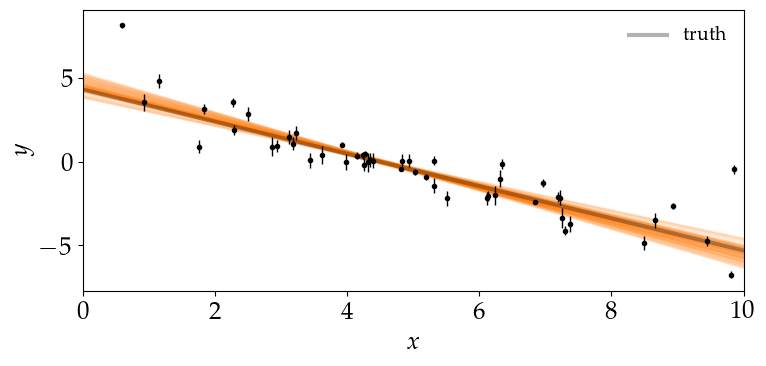

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, np.dot(np.vander(x0, 2), sample[:2][::-1]), "C1", alpha=0.1)

ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)
ax.plot(x0, a_true + b_true*x0, 'k', alpha=0.3, lw=3, label='truth')
ax.legend(fontsize=14).get_frame().set_linewidth(0)
ax.set(xlim=(0,10), xlabel='$x$', ylabel='$y$');

### Run MCMC with Random Seeds

Generate the MCMC samples again but instead of seeding near the ML value, instead uniformly distribute the seeds in the 3D parameter space.

In [17]:
pos = np.random.uniform(low=[2,-4,-8], high=[8,4,-1], size=(32,3))
nwalkers, ndim = pos.shape

bad_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, yerr))
bad_sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\andre\Documents\Rochester\403\PHYS403\venv2\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:13<00:00, 757.27it/s]


C:\Users\andre\AppData\Local\Temp\ipykernel_27812\2815355891.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


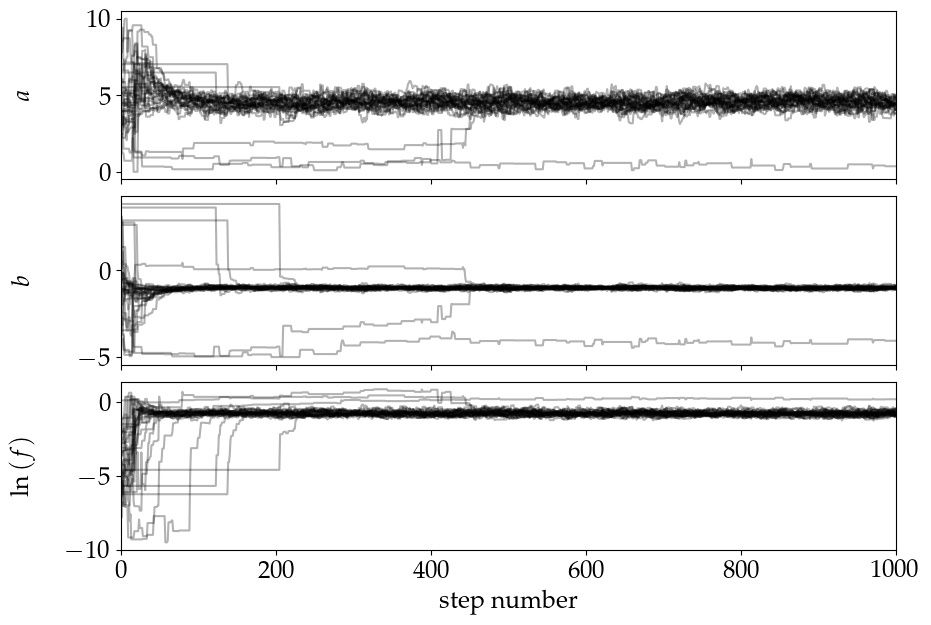

In [18]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
bad_samples = bad_sampler.get_chain()

labels = ['$a$', '$b$', r'$\ln{(f)}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(bad_samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number')
fig.tight_layout()

#### Extract Samples

Notice that some of the walkers don't appear to move off the seed values (e.g., the acceptance fraction is zero). Let's cut those from the final sample.

In [19]:
good_walkers = bad_sampler.acceptance_fraction > 0

C:\Users\andre\AppData\Local\Temp\ipykernel_27812\2115374261.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


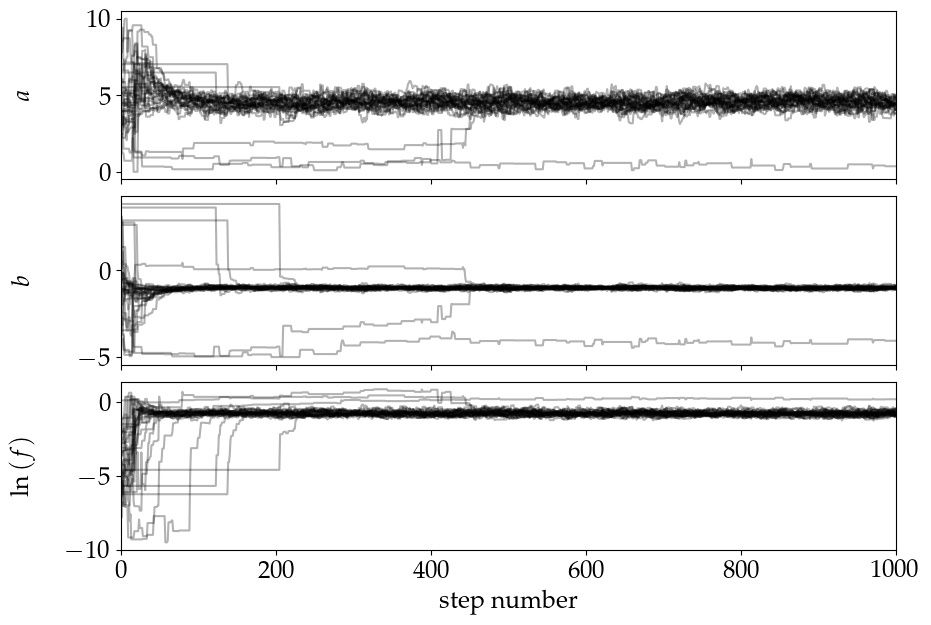

In [20]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})

bad_samples = bad_sampler.get_chain()[:,good_walkers,:]

labels = ['$a$', '$b$', r'$\ln{(f)}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(bad_samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number')
fig.tight_layout()

Flatten the samples for making corner plots.

In [21]:
bad_samples = bad_sampler.get_chain(discard=200, thin=15)[:,good_walkers,:]
ns, nw, nd = bad_samples.shape
flat_bad_samples = bad_samples.reshape(ns*nw, nd)

#### Corner Plot

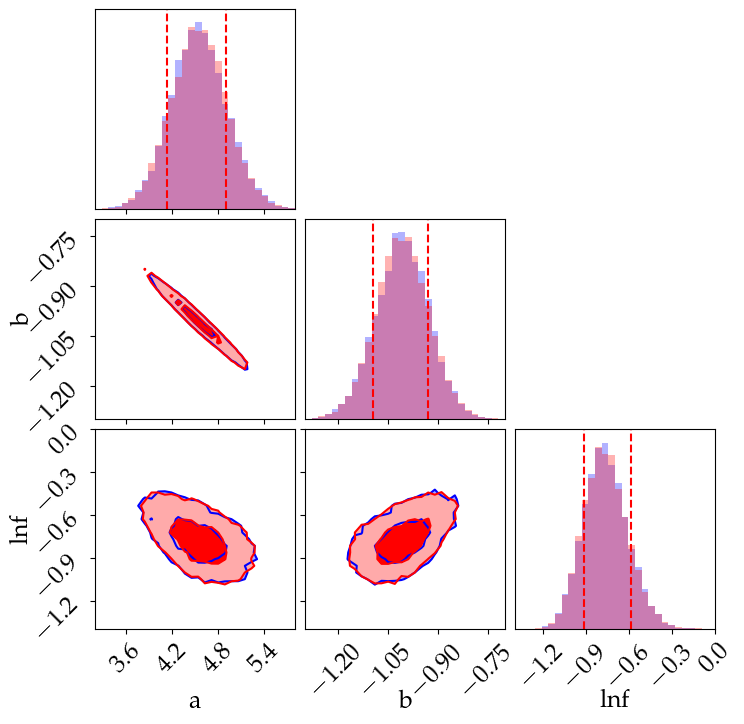

In [24]:
fig = corner.corner(flat_samples, labels=labels,
                    range=[(3.2,5.8), (-1.3,-0.7), (-1.4,0)], bins=30, #smooth=1,
#                     truths=[a_true, b_true, np.log(f_true)], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), #quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

corner.corner(flat_bad_samples, labels=labels, fig=fig,
                    range=[(3.2,5.8), (-1.3,-0.7), (-1.4,0)], bins=30, #smooth=1,
#                     truths=[a_true, b_true, np.log(f_true)], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                    color='r', plot_datapoints=False,
                    fill_contours=True);

## Parameter Uncertainties

Report the best-fit slope and intercept + central intervals from the MCMC set.

In [23]:
labels = ['a', 'b', 'lnf']
for i, label in enumerate(labels):
    x = soln.x[i]
    x16, x84 = np.percentile(flat_samples[:,i], [16,84])
    dlo = x - x16
    dhi = x84 - x
    print('{:3s} = {:5.2f} + {:4.2f} - {:4.2f}'.format(label, x, dhi, dlo))
    print('    = ({:5.2f}, {:5.2f})'.format(x16, x84))

a   =  4.53 + 0.39 - 0.34
    = ( 4.19,  4.92)
b   = -1.00 + 0.07 - 0.09
    = (-1.09, -0.93)
lnf = -0.79 + 0.18 - 0.13
    = (-0.92, -0.61)
